In [1]:
import pytorch_lightning as pl
import h5py
import os
import torch
import csv
import re
import numpy as np
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import library as lib
import pandas as pd
from matplotlib.pylab import plt
from sklearn.manifold import trustworthiness

In [2]:
pl.seed_everything(42, workers=True) 

Global seed set to 42


42

# Parameters

In [3]:
print(os.getcwd())
work_dir = str(os.getcwd())+"/"
inputs = "./inputs/"
out_path = "./out_dir/"

writer = True
gpu = False

epoch = 3

dim = 2560
dim3 = int(dim * 1/16)
dim2 = int(dim * 1/8)
dim1 = int(dim * 1/2)

/Users/adel.schmucklermann/Desktop/PyTorch_Lightning_VAE


# Data Pre-Processing

In [4]:
#make numpy file with (seq header, embedding)
esm2 = h5py.File(inputs+"KLK_esm2.h5", 'r')
list(esm2.keys())
# List all groups
keys = list(esm2.keys())
#print(keys) 
# Get the data
embedding = []
headers = []
for key in keys:
    #data
    emb = esm2[key][:]
    embedding.append(emb)
    #headers
    key = key.replace("isoform=", "isoform_").replace("=", "").replace(":", "_")
    if key == "GZMA_Canis_lupus":
        print("header is now changed")
        key = "GZMA_Canis_lupus_1"
    headers.append(key)

headers = np.array(headers)
embedding = np.array(embedding)

#split train test
headers_first, headers_test, embedding_first, embedding_test = train_test_split(headers, embedding, test_size=0.1, random_state=42)
#split train validation
headers_train, headers_validate, embedding_train, embedding_validate = train_test_split(headers_first, embedding_first, test_size =0.2, random_state=42)
print("total:", headers.shape)
print("training+validation:", headers_first.shape)
print("test:", headers_test.shape)
print("training:", headers_train.shape)
print("validation:", headers_validate.shape)
print(len(headers_train), len(embedding_train))
print(len(headers_validate), len(embedding_validate))

#training_df = pd.DataFrame({'header': headers_train, 'embedding' : embedding_train})
#validate_df = pd.DataFrame({'header': headers_validate, 'embedding' : embedding_validate})

header is now changed
total: (437,)
training+validation: (393,)
test: (44,)
training: (314,)
validation: (79,)
314 314
79 79


# Dataloaders

In [5]:
train_dataset = lib.makedataset(headers_train, embedding_train)
val_dataset = lib.makedataset(headers_validate, embedding_validate)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True)
    

# Training VAE

In [6]:
#if prott5 used: dtype=float16 -> error with .linear()

#encoder_layers, latent_dim, decoder_layers


encoder_layers = [dim, dim1, dim2, dim3]
latent_dim = dim3
decoder_layers = [dim3, dim2, dim1, dim]

# Initialize the VAE model
vae = lib.VariationalAutoencoder(encoder_layers, latent_dim, decoder_layers)

if gpu:
    trainer = pl.Trainer(accelerator="gpu", devices = 1, max_epochs=epoch, log_every_n_steps=4, check_val_every_n_epoch=1)
else:
    trainer = pl.Trainer(accelerator="auto", max_epochs=epoch, log_every_n_steps=4, check_val_every_n_epoch=1)

# Train the VAE model
trainer.fit(vae, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 3.7 M 
1 | latent  | Sequential | 26.1 K
2 | fc21    | Linear     | 25.8 K
3 | fc22    | Linear     | 25.8 K
4 | fc3     | Sequential | 26.1 K
5 | f

Sanity Checking: 0it [00:00, ?it/s]

/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/Users/adel.schmucklermann/miniconda3/envs/FP_lightning/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a b

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


# Fix Formatting

In [7]:
def find_largest_number(root_dir):
    largest_number = 0
    for subdir, dirs, files in os.walk(root_dir):
        for dir_name in dirs:
            match = re.search(r'\d+', dir_name)
            if match:
                current_number = int(match.group())
                if current_number > largest_number:
                    largest_number = current_number
    return largest_number

largest_num = find_largest_number(work_dir+"lightning_logs")

#Fix formatting
with open(work_dir+'lightning_logs/version_' + str(largest_num) + '/metrics.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

combined_rows = []
header_row = ['train_loss','reconstruction_loss','kl_loss','epoch','step','validation_loss']

combined_rows.append(header_row)
for i in range(1, len(rows) -1, 2):
    train_loss = rows[i][0]
    reconstruction_loss = rows[i][1]
    kl_loss = rows[i][2]
    epoch = rows[i+1][3]
    step = rows[i+1][4]
    validation_loss = rows[i+1][5]
    combined_rows.append([train_loss,reconstruction_loss,kl_loss,epoch,step,validation_loss])

with open(work_dir+'lightning_logs/version_' + str(largest_num) + '/new_metrics.csv', 'w', newline = "") as file:
    writer = csv.writer(file)
    writer.writerows(combined_rows)

# Plot Loss

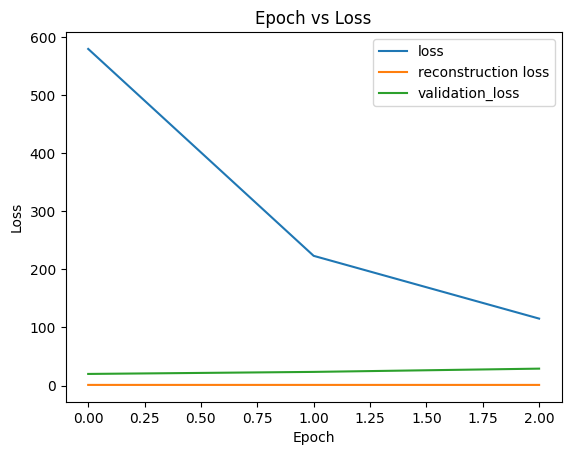

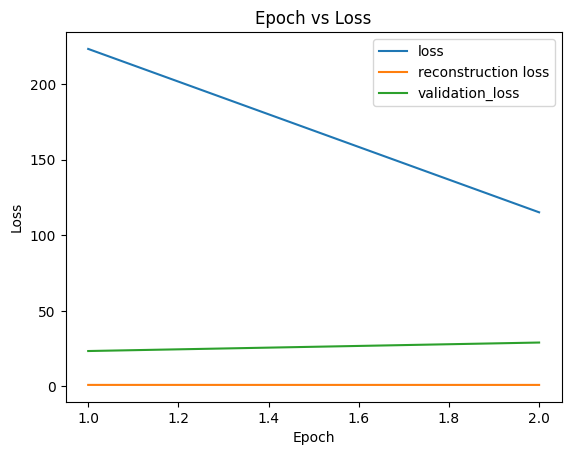

In [8]:
#Plot
# read csv file
df = pd.read_csv('lightning_logs/version_' + str(largest_num) + '/new_metrics.csv')

df1 = df[df['epoch'] >= int(epoch)/2]

# plot 0
plt.plot('epoch', 'train_loss', data=df)
plt.plot('epoch', 'reconstruction_loss', data=df)
plt.plot('epoch', 'validation_loss', data=df)
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'reconstruction loss', 'validation_loss'], loc='upper right')
plt.show()


# plot 1
plt.plot('epoch', 'train_loss', data=df1)
plt.plot('epoch', 'reconstruction_loss', data=df1)
plt.plot('epoch', 'validation_loss', data=df1)
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'reconstruction loss', 'validation_loss'], loc='upper right')
plt.show()

# Encode

In [9]:
encode = vae.encoder(torch.Tensor(embedding))
#mu, logvar = vae.encode(torch.Tensor(embedding))
#en = vae.reparameterize(mu, logvar)
#encode = vae.decode(en)
print(encode)

#encode = encode #[1]


tensor([[1.0139, 0.3981, 0.0000,  ..., 0.9422, 0.0000, 0.4428],
        [2.5902, 0.0000, 0.0000,  ..., 3.6544, 0.0000, 2.4699],
        [0.7932, 0.1756, 1.2143,  ..., 0.0000, 0.0579, 0.0000],
        ...,
        [0.0000, 0.7860, 0.3283,  ..., 0.0000, 0.5964, 0.0000],
        [0.4973, 0.7584, 0.0000,  ..., 0.6845, 0.0000, 0.0000],
        [0.3422, 0.5803, 0.0000,  ..., 0.8244, 0.8440, 0.0242]],
       grad_fn=<ReluBackward0>)


# Neighbor_joining and create tree

In [10]:
# Neighbor_joining and create tree

#cosine, euclidean, manhattan, ts_ss, jensenshannon
metric_list = ["cosine","euclidean", "manhattan", "ts_ss"]

for metric in metric_list:
    out_newick = out_path+"KLK_esm2_nj_"+str(epoch)+"_"+metric+".newick"

    embedding_out = encode.detach() #torch.stack(encode).detach() 
    #print(embedding_out)

    #distance metric
    dist = lib.distance_metric(embedding_out)
    distmat = dist.get_metric(embedding_out, metric) 
    
    #neighbor joining to tree
    nj = lib.neighbor_joining(distmat,headers)
    newick = nj.get_newick(distmat,headers)
    
    #trustworthiness
    _distmat  = lib.cophenetic_distmat(newick, names=headers)
    _trustworthiness = trustworthiness(distmat, _distmat, n_neighbors=10, metric='precomputed')
    print("trustworthiness: ", _trustworthiness)
    
    
    #silhouette = silhouette_score(_distmat, headers, metric='precomputed')
    #silhouette = lib.silhouette.get_silhouette(distmat, headers)
    #print("silhouette: ", silhouette)
    

    if writer:
        with open(out_newick, 'w') as w:
            w.write(newick)
            w.close()

trustworthiness:  0.9793920046906683
trustworthiness:  0.9728294122277689
trustworthiness:  0.9742007812351551
trustworthiness:  0.9376249691224813


# UPGMA and create tree

In [11]:
#write output flag
from sklearn.metrics import silhouette_score
from itertools import groupby
import string


#cosine, euclidean, manhattan, ts_ss, jensenshannon
metric_list = ["cosine","euclidean", "manhattan", "ts_ss"]

for metric in metric_list:
    out_newick = out_path+"KLK_esm2_upgma_"+str(epoch)+"_"+metric+".newick"

    embedding_out = encode.detach() #torch.stack(encode).detach() 
    #print(embedding_out)
    
    #distance metric
    dist = lib.distance_metric(embedding_out)
    distmat = dist.get_metric(embedding_out, metric)
    #print(distmat)
    
    #upgma to tree
    upgma = lib.upgma(distmat,headers)
   
    #trustworthiness
    _distmat  = lib.cophenetic_distmat(upgma, names=headers)
    _trustworthiness = trustworthiness(distmat, _distmat, n_neighbors=10, metric='precomputed')
    print("trustworthiness: ", _trustworthiness)
    
    
    if writer:
        with open(out_newick, 'w') as w:
            w.write(upgma)
            w.close()

trustworthiness:  0.9801314364357435
trustworthiness:  0.9732110719317247
trustworthiness:  0.9726030223322503
trustworthiness:  0.9726502547564951
